# Scikit Learn et données

Scikit-learn propose quelques ensembles de données, notamment [iris](http://en.wikipedia.org/wiki/Iris_flower_data_set) et [digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits) (classification) et le [boston house prices dataset](http://archive.ics.uci.edu/ml/datasets/Housing) (regression).

Exercice : en trouvez d'autres...

In [1]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
digits = datasets.load_digits()
boston = datasets.load_boston()

Un dataset ressemble à un `dict`.  Explorez les membres suivants (e.g., `iris.DESCR`) :
* `data`
* `target`
* `feature_names`
* `DESCR`


En anglais (pour correspondre aux noms des fonctions) : "We fit an estimator to the data to predict the classes to which unseen samples belong".  Donc, un `estimator` implemente les méthode `fit(X, y)` et `predit(T)`.

Le constructeur d'un estimateur accepte les paramètes du modèle.
Il est également possible de changer les paramètes après création.

In [2]:
from sklearn import svm

model = svm.SVC(gamma=0.002, C=100.)
print(model.gamma)
model.set_params(gamma=.001)
print(model.gamma)
model.fit(digits.data[:-1], digits.target[:-1])
model.predict(digits.data[-1])

0.002
0.001


/home/jeff/src/jma/MLWeek/venv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([8])

Nous pouvons regarder l'image.

* Qu'est-ce qui est l'effet de `cmap`?

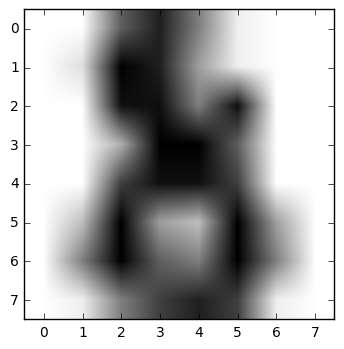

In [3]:
import pylab as pl
%matplotlib inline

pl.imshow(digits.images[-1], cmap=pl.cm.gray_r)

À savoir (mais pour un autre jour) :
* pickle marche
* `sklearn.externals.joblib` est parfois plus efficace

Un estimator prend un ensemble de données, typiquement un array de dimension 2 (`np.ndarray`, cf. `.shape`).

Regardons les iris :
* Il y a combien de classes d'iris?
* Il y a combien de vecteurs dans le training data?
* Il y a combien de dimensions?

In [4]:
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target

Le classifieur le plus simple imagineable s'appelle kNN.  Avec scikit-learn, c'est facile.  (Visualisaton à suivre.)

Le nombre de dimensions peut monter très vite, ce qui pose des problèmes pour kNN.
* Il y a combien de point sur une lattice espacés de $1/n$ en dimension 1, 2, 3, ..., n ?
* Qu'est-ce qui est la distance entre 0 et 1 (les vecteurs des coins opposés) dans $[0,1]^d$?

In [5]:
# Split iris data in train and test data
# A random permutation, to split the data randomly
np.random.seed(0)
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-10]]
iris_y_train = iris_y[indices[:-10]]
iris_X_test  = iris_X[indices[-10:]]
iris_y_test  = iris_y[indices[-10:]]
# Create and fit a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(iris_X_train, iris_y_train) 
print(knn.predict(iris_X_test))
print(iris_y_test)
knn.score(iris_X_test, iris_y_test)

[1 2 1 0 0 0 2 1 2 0]
[1 1 1 0 0 0 2 1 2 0]


0.90000000000000002

La régression logistique est un algorithm important de classification dans l'apprentissage.  Le voilà sur les mêmes données :

In [6]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(iris_X_train, iris_y_train)
print(logistic.predict(iris_X_test))
print(iris_y_test)
logistic.score(iris_X_test, iris_y_test)

[1 2 1 0 0 0 2 1 2 0]
[1 1 1 0 0 0 2 1 2 0]


0.90000000000000002

Exercice :
* Pourquoi sont les scores les mêmes dans les deux exemples précédents?
* À quoi sert le score?

In [7]:
scores = []
for k in range(10):
    indices = np.random.permutation(len(iris_X))
    iris_X_train = iris_X[indices[:-10]]
    iris_y_train = iris_y[indices[:-10]]
    iris_X_test  = iris_X[indices[-10:]]
    iris_y_test  = iris_y[indices[-10:]]
    
    knn = KNeighborsClassifier()
    knn.fit(iris_X_train, iris_y_train) 
    scores.append(knn.score(iris_X_test, iris_y_test))
print(scores)

[0.90000000000000002, 0.90000000000000002, 1.0, 0.90000000000000002, 1.0, 1.0, 0.69999999999999996, 1.0, 1.0, 1.0]


In [8]:
X_digits = digits.data
y_digits = digits.target
svc = svm.SVC(C=1, kernel='linear')

N = 10
X_folds = np.array_split(X_digits, N)
y_folds = np.array_split(y_digits, N)
scores = list()
for k in range(N):
     # We use 'list' to copy, in order to 'pop' later on
     X_train = list(X_folds)
     X_test  = X_train.pop(k)
     X_train = np.concatenate(X_train)
     y_train = list(y_folds)
     y_test  = y_train.pop(k)
     y_train = np.concatenate(y_train)
     scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
scores

[0.93888888888888888,
 0.99444444444444446,
 0.93333333333333335,
 0.96666666666666667,
 0.96111111111111114,
 0.98888888888888893,
 0.96666666666666667,
 0.98882681564245811,
 0.93296089385474856,
 0.96648044692737434]

Ce qu'on vient de faire s'appelle "cross validation" (validation croisée).  On peut le faire plus facilement :

In [9]:
from sklearn import cross_validation

k_fold = cross_validation.KFold(n=6, n_folds=3)
for train_indices, test_indices in k_fold:
    print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5] | test: [0 1]
Train: [0 1 4 5] | test: [2 3]
Train: [0 1 2 3] | test: [4 5]


/home/jeff/src/jma/MLWeek/venv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
kfold = cross_validation.KFold(len(X_digits), n_folds=N)
[svc.fit(X_digits[train], y_digits[train]).score(
        X_digits[test], y_digits[test])
 for train, test in kfold]

[0.93888888888888888,
 0.99444444444444446,
 0.93333333333333335,
 0.96666666666666667,
 0.96111111111111114,
 0.98888888888888893,
 0.96666666666666667,
 0.98882681564245811,
 0.93296089385474856,
 0.96648044692737434]

In [11]:
cross_validation.cross_val_score(
    svc, X_digits, y_digits, cv=kfold, n_jobs=-1)

array([ 0.93888889,  0.99444444,  0.93333333,  0.96666667,  0.96111111,
        0.98888889,  0.96666667,  0.98882682,  0.93296089,  0.96648045])

En validation croisée, plus c'est grand, plus c'est bon.

À voir également :
* KFold
* StratifiedKFold
* LeaveOneOut
* LeaveOneLabelOut

## Estimation d'un paramètre

Nous voudrions trouver quelle valeur du paramètre $C$ nous donne un bon rendu de SVM avec noyau linéaire.  Pour l'instant, on ne parle ni de SVM ni des noyaux : ce sont simplement des classificateurs.  L'important ici est qu'il existe un paramètre $C$ qui touche sur la qualité de nos résultats.

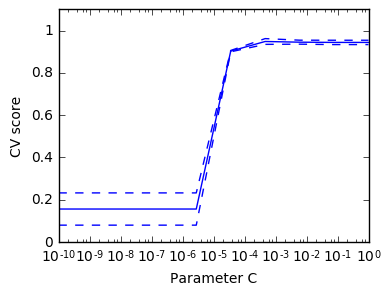

In [12]:
import numpy as np
from sklearn import cross_validation, datasets, svm

digits = datasets.load_digits()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_validation.cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

## Grid search

Note pour plus tard : Voir l'argument `cv`.  `GridSearch` fait 3-fold validation croisée pour la régression, stratified 3-fold pour un classificateur.

In [13]:
from sklearn.grid_search import GridSearchCV
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_digits[:1000], y_digits[:1000])
print(clf.best_score_)
print(clf.best_estimator_.C)

# Prediction performance on test set is not as good as on train set
print(clf.score(X_digits[1000:], y_digits[1000:]))

/home/jeff/src/jma/MLWeek/venv/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.925
0.00774263682681
0.943538268507
